[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ilya16/isp-tts/blob/main/notebooks/training.ipynb)

# Setup

Before running the code in Colab: switch the Runtime to GPU

Run two cells below once to download dataset, models and install packages.

In [1]:
#@title Download models and code

import os
import IPython.display as ipd

INDEX_ID = "1ejkNbKM5k11ALiXoS_qYbb01O1s2JVpq"
INDEX_FILE = "/content/index.txt"

!gdown {INDEX_ID} -O {INDEX_FILE}

FILE_INDEX = {}
with open(INDEX_FILE, 'r') as f:
    for line in f:
        gid, name = line.strip().split('\t')
        FILE_INDEX[name] = gid

for name, gid in FILE_INDEX.items():
    path = os.path.join("/content", name)
    if not os.path.exists(path):
        !gdown {gid} -O {path}

if os.path.exists("/content/dataset.tar.gz"):
    !tar -xzvf /content/dataset.tar.gz

!git clone https://github.com/ilya16/isp-tts

ipd.clear_output()
print('Successfully downloaded data and code')

Successfully downloaded data and code


In [3]:
#@title Install dependencies
!pip install -r /content/isp-tts/requirements.txt
!apt-get install espeak-ng

ipd.clear_output()
print('Installed required Python libraries')

Installed required Python libraries


# Initialization

Start from here after loading data and installing packages.

In [4]:
#@title Imports
from __future__ import annotations
import os
import sys
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import IPython.display as ipd

CONTENT_DIR = "/content" # @param {type:"string"}

os.chdir(CONTENT_DIR)
sys.path.append(os.path.join(CONTENT_DIR, 'isp-tts'))

os.environ['OMP_NUM_THREADS'] = '1'

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ipd.clear_output()

# Dataset

The dataset should have the following structure:

```
DATASET_ROOT
  wavs
    audio_1.wav
    audio_2.wav
    ...
    audio_N.wav
  meta.csv
  (meta_train.csv) – can be computed below
  (meta_val.csv) – can be computed below
```

The metadata files should have the following structure:

```
wavs/audio_1.wav|This is the sample text.
wavs/audio_2.wav|The second audio св+язяно с +этим т+екстом.
...
wavs/audio_N.wav|нижний текст.
```

In other words, the metadata files should contain the "|"-separated paths to audios (relative to the dataset root) and matched texts.


In [5]:
#@title Dataset root

#@markdown Change the path to your dataset here
DATASET_ROOT = "/content/dataset" # @param {type:"string"}

## Split metadata into train and validation:

Use the cell below to split your metadata into training and validation sets

In [6]:
#@title Split Data

SPLIT_DATA = True # @param {"type":"boolean"}
META_NAME = "meta.csv" # @param {"type":"string","placeholder":"meta.csv"}
RANDOM_SEED = 42 # @param {"type":"integer"}
VAL_RATIO = 0.1 # @param {"type":"number","placeholder":"0.1"}


def load_meta(filename, split="|"):
    with open(filename, encoding='utf-8') as f:
        meta = [line.strip().split(split) for line in f]
    return meta


def split_meta(meta_name, val_size: float = 0.1, seed: int = 42):
    meta_path = os.path.join(DATASET_ROOT, meta_name)
    meta = load_meta(meta_path)

    ids = np.arange(len(meta))

    np.random.seed(seed)
    np.random.shuffle(ids)
    ids = set(np.sort(ids[:int((1 - val_size) * len(meta))]))

    meta_train = []
    for i, x in enumerate(meta):
        if i in ids:
            meta_train.append(x)

    meta_valid = []
    for i, x in enumerate(meta):
        if i not in ids:
            meta_valid.append(x)

    train_meta_path = os.path.join(DATASET_ROOT, meta_name.replace(".csv", "_train.csv"))
    with open(train_meta_path, "w", encoding="utf-8") as f:
        f.writelines(['|'.join(item) + '\n' for item in meta_train])

    valid_meta_path = os.path.join(DATASET_ROOT, meta_name.replace(".csv", "_valid.csv"))
    with open(valid_meta_path, "w", encoding="utf-8") as f:
        f.writelines(['|'.join(item) + '\n' for item in meta_valid])

    print(f"Split metadata `{meta_path}` ({len(meta)} samples) into:"
          f"\n\ttrain: `{train_meta_path}` ({len(meta_train)} samples)"
          f"\n\tvalid: `{valid_meta_path}` ({len(meta_valid)} samples)")


if SPLIT_DATA:
    split_meta(META_NAME, VAL_RATIO, RANDOM_SEED)

Split metadata `/content/dataset/meta.csv` (529 samples) into:
	train: `/content/dataset/meta_train.csv` (476 samples)
	valid: `/content/dataset/meta_valid.csv` (53 samples)


# Training

The are two options to run the training:
1. directly in the notebook by initializing the model, dataset, and trainer
2. using the `train.py` script


Before the training, you need to complete the training conifguration file. The example files for training in Colab are provided in:
- for training an English-only model: `isp-tts/recipes/colab/train_en_ipa.yaml`
- for training a Russian or multi-language model: `isp-tts/recipes/colab/train_ru_en.yaml`

Modify the following arguments in the selected/copied dataset specific to your data:
```yaml
_general_:
  _dirname_: /content/results  # directory where all logs and checkpoints will be stored
  _label_: voice_ru_en  # name for the experiment
```

```yaml
dataset:
  root: /content/dataset  # path to your dataset

  _train_:
    meta_name: meta_train.csv  # training metadata path relative to the dataset root

  _eval_:
    meta_name: meta_valid.csv  # validation metadata path relative to the dataset root
```

Also, you are free to tune the training parameters in the `trainer` section:
```yaml
trainer:
  epochs: 50
  batch_size: 24  # enough for T4 GPU
  eval_batch_size: 48

  eval_strategy: steps
  eval_steps: 50

  project_name: isp-tts  # wandb project name
  accelerator:
    log_with: [tensorboard]
#    log_with: [wandb, tensorboard]  # change to this to store logs in wandb
```

## Training in the notebook

In [7]:
#@title Initilize Experiment Modules
from tts.experiments.modules import ExperimentModules
from tts.experiments import Trainer

CONFIG_ROOT = "/content/isp-tts/recipes" # @param {"type":"string"}
CONFIG_NAME = "colab/train_ru_en.yaml" # @param {"type":"string"}

exp_modules = ExperimentModules(
    config=CONFIG_NAME,
    config_root=CONFIG_ROOT
)
modules = exp_modules.init_modules()
print(modules.keys())

2025-01-30 21:30:34.451 | DEBUG    | tts.data.dataset:__init__:83 - text_length_limits: 476 samples


  0%|          | 0/476 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/soundfile_backend.py:71: UserWarning: The MPEG_LAYER_III subtype is unknown to TorchAudio. As a result, the bits_per_sample attribute will be set to 0. If you are seeing this warning, please report by opening an issue on github (after checking for existing/closed ones). You may otherwise ignore this warning.
  warnings.warn(
2025-01-30 21:30:34.520 | DEBUG    | tts.data.dataset:__init__:87 - audio_length_limits: 476 samples
2025-01-30 21:30:34.538 | DEBUG    | tts.data.dataset:__init__:83 - text_length_limits: 53 samples


  0%|          | 0/53 [00:00<?, ?it/s]

2025-01-30 21:30:34.567 | DEBUG    | tts.data.dataset:__init__:87 - audio_length_limits: 53 samples
ERROR:numba.cuda.cudadrv.driver:Call to cuLinkAddData results in CUDA_ERROR_UNSUPPORTED_PTX_VERSION


dict_keys(['model', 'criterion', 'train_dataset', 'eval_dataset', 'collator', 'evaluator'])


In [8]:
#@title Inspect the datasets

print(f"Training dataset: {len(modules['train_dataset'])} samples")
print(modules["train_dataset"].meta[:5])
print()
print(f"Validation dataset: {len(modules['eval_dataset'])} samples")
print(modules["eval_dataset"].meta[:5])

Training dataset: 476 samples
[('wavs/AXxnsJaFCic_12_1_short_1.wav', 'but while he may make gains on the battlefield.')
 ('wavs/AXxnsJaFCic_12_1_short_2.wav', "he'll pay a continuing high price over the long run.")
 ('wavs/AXxnsJaFCic_12_2_short_1.wav', 'that they will not tolerate anyone.')
 ('wavs/AXxnsJaFCic_12_2_short_2.wav', 'who tries to take their country backwards.')
 ('wavs/AXxnsJaFCic_12_3_short.wav', "and i'm taking robust action to make sure the pain of our sanctions is targeted at russian economy.")]

Validation dataset: 53 samples
[('wavs/AXxnsJaFCic_24_2_short_2.wav', "you'll find a thousand empty acres of land.")
 ('wavs/AXxnsJaFCic_24_2_short_3.wav', "it won't look like much.")
 ('wavs/AXxnsJaFCic_46_1_long.wav', 'my plan will not only lower costs to give families a fair shot, it will lower the deficit. the previous administration not only ballooned the deficit with those tax cuts for the very wealthy and corporations.')
 ('wavs/AXxnsJaFCic_48_long.wav', "the only pres

In [9]:
#@title Initialize the Trainer

trainer = Trainer(
    **modules,
    config=exp_modules.config
)

2025-01-30 21:30:44 INFO    - Initialized output directory: /content/results/AcousticModel/25-01-30/voice_ru_en
2025-01-30 21:30:44 INFO    - Initialized logs directory: /content/results/AcousticModel/25-01-30/voice_ru_en/logs
2025-01-30 21:30:44 INFO    - Built CallbackHandler
2025-01-30 21:30:47 INFO    - Built TrackerCallback
2025-01-30 21:30:47 INFO    - Built Training DataLoader
2025-01-30 21:30:47 INFO    - Built Evaluation DataLoader
2025-01-30 21:30:49 WARNING - The following params are incompatible with the ExponentialLR constructor, so they will be ignored: ['total_steps'].
2025-01-30 21:30:49 INFO    - Built Optimizer
2025-01-30 21:30:49 INFO    - Built Trainer!


In [ ]:
# Uncomment to see the Tensorboard logs in Colab

# %load_ext tensorboard
# %tensorboard --logdir /content/results

In [10]:
#@title Run Training

trainer.train()

2025-01-30 21:30:55 INFO    - *** Loading checkpoint ***
2025-01-30 21:30:55 INFO    - Checkpoint path: `/content/acoustic_ru_en.pt`
2025-01-30 21:30:56 INFO    - Warm start is enabled.
2025-01-30 21:30:56 WARNING - The following checkpoint keys are not presented in the model and will be ignored: ['speaker_embedding.weight']
2025-01-30 21:30:56 INFO    - Automatically found the checkpoint keys incompatible with the model: []
2025-01-30 21:30:56 INFO    - Loaded checkpoint `/content/acoustic_ru_en.pt`.
2025-01-30 21:30:56 INFO    - The model graph has been frozen, except for the following parameters: ['aligner.attention.key_proj.0.conv.weight', 'aligner.attention.key_proj.0.norm.weight', 'aligner.attention.key_proj.0.norm.bias', 'aligner.attention.key_proj.1.conv.weight', 'aligner.attention.query_proj.0.conv.weight', 'aligner.attention.query_proj.0.norm.weight', 'aligner.attention.query_proj.0.norm.bias', 'aligner.attention.query_proj.1.conv.weight', 'aligner.attention.query_proj.1.norm

  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-30 21:30:56 WARNING - The coding table does not contain the following characters: {'2', '5'}
2025-01-30 21:30:56 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:30:57 WARNING - The coding table does not contain the following characters: {'1', '4', '0', '7', '2', '9'}
2025-01-30 21:30:57 WARNING - The coding table does not contain the following characters: {'2', ' \\'}
2025-01-30 21:30:57 WARNING - The coding table does not contain the following characters: {'6', '1', '0', '7', '3'}
2025-01-30 21:30:57 WARNING - The coding table does not contain the following characters: {'1', '4', '2', '5', '0', '7', '3'}
2025-01-30 21:30:57 WARNING - The coding table does not contain the following characters: {'1', '9', '8'}
2025-01-30 21:31:07 INFO    - [EVAL]  epoch:   0/ 50 (step: 0), loss: 5.27363
2025-01-30 21:31:07 INFO    - {'loss': 5.27363, 'loss/model/mel_loss': 1.2412, 'loss/adaptor/flow_loss': 1.04632, 'loss/aligner/attention_loss': 1.9797

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:31:07 WARNING - The coding table does not contain the following characters: {'2', '9'}
2025-01-30 21:31:07 WARNING - The coding table does not contain the following characters: {'6'}
2025-01-30 21:31:08 WARNING - The coding table does not contain the following characters: {'1', '0', '9', '6'}
2025-01-30 21:31:08 WARNING - The coding table does not contain the following characters: {'1', '9', ' \\', '6'}
2025-01-30 21:31:10 WARNING - The coding table does not contain the following characters: {'1', '4'}
2025-01-30 21:31:11 WARNING - The coding table does not contain the following characters: {'%', '\\\\', '1', '4', '5', '2'}
2025-01-30 21:31:11 WARNING - The coding table does not contain the following characters: {'1', '9'}
2025-01-30 21:31:12 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:31:12 WARNING - The coding table does not contain the following characters: {'3', '0'}
2025-01-30 21:31:13 WARNING - The coding table does no

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:31:30 WARNING - The coding table does not contain the following characters: {'1', '9', '6'}
2025-01-30 21:31:30 WARNING - The coding table does not contain the following characters: {'1', '9', '7', '0'}
2025-01-30 21:31:32 WARNING - The coding table does not contain the following characters: {'1', '2', '0', '7', '3', '9'}
2025-01-30 21:31:33 WARNING - The coding table does not contain the following characters: {'1', '7'}
2025-01-30 21:31:34 WARNING - The coding table does not contain the following characters: {'%', '6', '\\\\', '1', '5', '0', '9'}
2025-01-30 21:31:34 WARNING - The coding table does not contain the following characters: {'1', '9', ' \\', '6'}
2025-01-30 21:31:35 WARNING - The coding table does not contain the following characters: {'1', '2'}
2025-01-30 21:31:35 WARNING - The coding table does not contain the following characters: {'2', '1'}
2025-01-30 21:31:36 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:31:38

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:31:52 WARNING - The coding table does not contain the following characters: {'1', '4'}
2025-01-30 21:31:53 WARNING - The coding table does not contain the following characters: {'1', '0', '9', '6'}
2025-01-30 21:31:53 WARNING - The coding table does not contain the following characters: {'8', '1', '0', '7', '9'}
2025-01-30 21:31:53 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:31:53 WARNING - The coding table does not contain the following characters: {'6'}
2025-01-30 21:31:54 WARNING - The coding table does not contain the following characters: {'2', '0', '1', '5'}
2025-01-30 21:31:54 WARNING - The coding table does not contain the following characters: {'2', '0', '1'}
2025-01-30 21:31:54 WARNING - The coding table does not contain the following characters: {'%', '6', '\\\\', '1', '5', '0', '9'}
2025-01-30 21:31:55 WARNING - The coding table does not contain the following characters: {'2', '0', '1'}
2025-01-30 21:31:56 WARNIN

  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-30 21:32:07 WARNING - The coding table does not contain the following characters: {'2', '5'}
2025-01-30 21:32:07 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:32:08 WARNING - The coding table does not contain the following characters: {'1', '4', '0', '7', '2', '9'}
2025-01-30 21:32:08 WARNING - The coding table does not contain the following characters: {'2', ' \\'}
2025-01-30 21:32:08 WARNING - The coding table does not contain the following characters: {'6', '1', '0', '7', '3'}
2025-01-30 21:32:09 WARNING - The coding table does not contain the following characters: {'1', '4', '2', '5', '0', '7', '3'}
2025-01-30 21:32:09 WARNING - The coding table does not contain the following characters: {'1', '9', '8'}
2025-01-30 21:32:11 INFO    - [EVAL]  epoch:   2/ 50 (step: 50), loss: 3.78863
2025-01-30 21:32:11 INFO    - {'loss': 3.78863, 'loss/model/mel_loss': 0.49752, 'loss/adaptor/flow_loss': 0.63061, 'loss/aligner/attention_loss': 1.86

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:32:20 WARNING - The coding table does not contain the following characters: {'%', '6', '\\\\', '1', '5', '0', '9'}
2025-01-30 21:32:20 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:32:21 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:32:21 WARNING - The coding table does not contain the following characters: {'2', '0'}
2025-01-30 21:32:22 WARNING - The coding table does not contain the following characters: {'1', '9', '6'}
2025-01-30 21:32:23 WARNING - The coding table does not contain the following characters: {'1', '9', '0', '5'}
2025-01-30 21:32:24 WARNING - The coding table does not contain the following characters: {'1', '0'}
2025-01-30 21:32:24 WARNING - The coding table does not contain the following characters: {'1', '0'}
2025-01-30 21:32:24 WARNING - The coding table does not contain the following characters: {'1', '9', '2'}
2025-01-30 21:32:25 WARNING - The coding table do

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:32:43 WARNING - The coding table does not contain the following characters: {'1', '0', '9', '8'}
2025-01-30 21:32:44 WARNING - The coding table does not contain the following characters: {'2', '0', '1'}
2025-01-30 21:32:44 WARNING - The coding table does not contain the following characters: {'2', '0', '1'}
2025-01-30 21:32:44 WARNING - The coding table does not contain the following characters: {'%', '6', '\\\\', '1', '5', '0', '9'}
2025-01-30 21:32:44 WARNING - The coding table does not contain the following characters: {'1', '4'}
2025-01-30 21:32:45 WARNING - The coding table does not contain the following characters: {'1', '9', ' \\', '6'}
2025-01-30 21:32:45 WARNING - The coding table does not contain the following characters: {'5'}
2025-01-30 21:32:46 WARNING - The coding table does not contain the following characters: {'1', '0'}
2025-01-30 21:32:46 WARNING - The coding table does not contain the following characters: {'6'}
2025-01-30 21:32:46 WARNING - The coding 

  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-30 21:33:05 WARNING - The coding table does not contain the following characters: {'2', '5'}
2025-01-30 21:33:05 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:33:06 WARNING - The coding table does not contain the following characters: {'1', '4', '0', '7', '2', '9'}
2025-01-30 21:33:06 WARNING - The coding table does not contain the following characters: {'2', ' \\'}
2025-01-30 21:33:06 WARNING - The coding table does not contain the following characters: {'6', '1', '0', '7', '3'}
2025-01-30 21:33:06 WARNING - The coding table does not contain the following characters: {'1', '4', '2', '5', '0', '7', '3'}
2025-01-30 21:33:06 WARNING - The coding table does not contain the following characters: {'1', '9', '8'}
2025-01-30 21:33:08 INFO    - [EVAL]  epoch:   5/ 50 (step: 100), loss: 3.63579
2025-01-30 21:33:08 INFO    - {'loss': 3.63579, 'loss/model/mel_loss': 0.46293, 'loss/adaptor/flow_loss': 0.58415, 'loss/aligner/attention_loss': 1.8

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:33:10 WARNING - The coding table does not contain the following characters: {'1', '9', '7', '0'}
2025-01-30 21:33:10 WARNING - The coding table does not contain the following characters: {'2', '1'}
2025-01-30 21:33:10 WARNING - The coding table does not contain the following characters: {'1', '9', '6', '8'}
2025-01-30 21:33:10 WARNING - The coding table does not contain the following characters: {'1', '7'}
2025-01-30 21:33:11 WARNING - The coding table does not contain the following characters: {'1', '2', '0', '7', '3', '9'}
2025-01-30 21:33:12 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:33:13 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:33:13 WARNING - The coding table does not contain the following characters: {'1', '0', '3', '6'}
2025-01-30 21:33:13 WARNING - The coding table does not contain the following characters: {'5'}
2025-01-30 21:33:14 WARNING - The coding table does 

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:33:33 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:33:33 WARNING - The coding table does not contain the following characters: {'1', '2'}
2025-01-30 21:33:34 WARNING - The coding table does not contain the following characters: {'1', '9', '7', '0'}
2025-01-30 21:33:34 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:33:34 WARNING - The coding table does not contain the following characters: {'2', '0', '1'}
2025-01-30 21:33:34 WARNING - The coding table does not contain the following characters: {'8', '1', '0', '7', '9'}
2025-01-30 21:33:35 WARNING - The coding table does not contain the following characters: {'1', '0', '5'}
2025-01-30 21:33:35 WARNING - The coding table does not contain the following characters: {'1', '9', ' \\', '6'}
2025-01-30 21:33:36 WARNING - The coding table does not contain the following characters: {'1', '4'}
2025-01-30 21:33:36 WARNING - The coding table doe

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:33:56 WARNING - The coding table does not contain the following characters: {'6'}
2025-01-30 21:33:57 WARNING - The coding table does not contain the following characters: {'1', '9', '7', '0'}
2025-01-30 21:33:57 WARNING - The coding table does not contain the following characters: {'1', '9', '6'}
2025-01-30 21:33:59 WARNING - The coding table does not contain the following characters: {'2', '1'}
2025-01-30 21:33:59 WARNING - The coding table does not contain the following characters: {'2', '9'}
2025-01-30 21:33:59 WARNING - The coding table does not contain the following characters: {'1', '0', '3', '6'}
2025-01-30 21:34:00 WARNING - The coding table does not contain the following characters: {'1', '9', '2'}
2025-01-30 21:34:00 WARNING - The coding table does not contain the following characters: {'2', '0'}
2025-01-30 21:34:01 WARNING - The coding table does not contain the following characters: {'1', '9', ' \\', '6'}
2025-01-30 21:34:01 WARNING - The coding table does no

  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-30 21:34:09 WARNING - The coding table does not contain the following characters: {'1', '4', '2', '5'}
2025-01-30 21:34:10 WARNING - The coding table does not contain the following characters: {'2', '5'}
2025-01-30 21:34:10 WARNING - The coding table does not contain the following characters: {'1', '9', '6', '8'}
2025-01-30 21:34:10 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:34:10 WARNING - The coding table does not contain the following characters: {'%', '6', '\\\\', '1', '5', '0', '9'}
2025-01-30 21:34:11 WARNING - The coding table does not contain the following characters: {'2', '0', '1', '5'}
2025-01-30 21:34:11 WARNING - The coding table does not contain the following characters: {'1', '0'}
2025-01-30 21:34:12 WARNING - The coding table does not contain the following characters: {'1', '4', '0', '7', '2', '9'}
2025-01-30 21:34:12 WARNING - The coding table does not contain the following characters: {'2', ' \\'}
2025-01-30 21:

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:34:24 WARNING - The coding table does not contain the following characters: {'2', '1'}
2025-01-30 21:34:24 WARNING - The coding table does not contain the following characters: {'1', '7'}
2025-01-30 21:34:25 WARNING - The coding table does not contain the following characters: {'2', '0', '1'}
2025-01-30 21:34:25 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:34:25 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:34:25 WARNING - The coding table does not contain the following characters: {'2', '0'}
2025-01-30 21:34:25 WARNING - The coding table does not contain the following characters: {'1', '0', '9', '6'}
2025-01-30 21:34:26 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:34:26 WARNING - The coding table does not contain the following characters: {'1', '4', '2', '5'}
2025-01-30 21:34:27 WARNING - The coding table does not contain the followi

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:34:45 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:34:45 WARNING - The coding table does not contain the following characters: {'1', '9', '7', '0'}
2025-01-30 21:34:46 WARNING - The coding table does not contain the following characters: {'1', '9', '6'}
2025-01-30 21:34:46 WARNING - The coding table does not contain the following characters: {'6'}
2025-01-30 21:34:46 WARNING - The coding table does not contain the following characters: {'2', '0', '1'}
2025-01-30 21:34:47 WARNING - The coding table does not contain the following characters: {'2', '0', '1'}
2025-01-30 21:34:48 WARNING - The coding table does not contain the following characters: {'2', '0'}
2025-01-30 21:34:48 WARNING - The coding table does not contain the following characters: {'1', '0', '5'}
2025-01-30 21:34:49 WARNING - The coding table does not contain the following characters: {'1', '2'}
2025-01-30 21:34:49 WARNING - The coding table does not contain the f

  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-30 21:35:09 WARNING - The coding table does not contain the following characters: {'2', '5'}
2025-01-30 21:35:09 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:35:10 WARNING - The coding table does not contain the following characters: {'1', '4', '0', '7', '2', '9'}
2025-01-30 21:35:10 WARNING - The coding table does not contain the following characters: {'2', ' \\'}
2025-01-30 21:35:10 WARNING - The coding table does not contain the following characters: {'6', '1', '0', '7', '3'}
2025-01-30 21:35:10 WARNING - The coding table does not contain the following characters: {'1', '4', '2', '5', '0', '7', '3'}
2025-01-30 21:35:10 WARNING - The coding table does not contain the following characters: {'1', '9', '8'}
2025-01-30 21:35:12 INFO    - [EVAL]  epoch:  10/ 50 (step: 200), loss: 3.45565
2025-01-30 21:35:12 INFO    - {'loss': 3.45565, 'loss/model/mel_loss': 0.43976, 'loss/adaptor/flow_loss': 0.50406, 'loss/aligner/attention_loss': 1.7

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:35:13 WARNING - The coding table does not contain the following characters: {'%', '\\\\', '1', '4', '5', '2'}
2025-01-30 21:35:14 WARNING - The coding table does not contain the following characters: {'2', '9'}
2025-01-30 21:35:14 WARNING - The coding table does not contain the following characters: {'2', '0', '1'}
2025-01-30 21:35:14 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:35:15 WARNING - The coding table does not contain the following characters: {'1', '9', '6'}
2025-01-30 21:35:15 WARNING - The coding table does not contain the following characters: {'1', '9', '0', '5'}
2025-01-30 21:35:15 WARNING - The coding table does not contain the following characters: {'1', '0', '9', '6'}
2025-01-30 21:35:16 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:35:16 WARNING - The coding table does not contain the following characters: {'%', '6', '\\\\', '1', '5', '0', '9'}
2025-01-30 21:35

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:35:36 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:35:36 WARNING - The coding table does not contain the following characters: {'1', '9', '0', '5'}
2025-01-30 21:35:36 WARNING - The coding table does not contain the following characters: {'1', '7'}
2025-01-30 21:35:36 WARNING - The coding table does not contain the following characters: {'1', '9'}
2025-01-30 21:35:36 WARNING - The coding table does not contain the following characters: {'2', '0', '1', '5'}
2025-01-30 21:35:36 WARNING - The coding table does not contain the following characters: {'1', '0', '9', '8'}
2025-01-30 21:35:37 WARNING - The coding table does not contain the following characters: {'%', '\\\\', '1', '4', '5', '2'}
2025-01-30 21:35:37 WARNING - The coding table does not contain the following characters: {'1', '0'}
2025-01-30 21:35:38 WARNING - The coding table does not contain the following characters: {'1', '9', '2'}
2025-01-30 21:35:39 WARNING - The co

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:35:58 WARNING - The coding table does not contain the following characters: {'1', '4'}
2025-01-30 21:35:58 WARNING - The coding table does not contain the following characters: {'2', '0', '1', '5'}
2025-01-30 21:35:58 WARNING - The coding table does not contain the following characters: {'1', '9', '6'}
2025-01-30 21:35:59 WARNING - The coding table does not contain the following characters: {'1', '9', '2'}
2025-01-30 21:35:59 WARNING - The coding table does not contain the following characters: {'2', '0'}
2025-01-30 21:35:59 WARNING - The coding table does not contain the following characters: {'2', '0', '1'}
2025-01-30 21:35:59 WARNING - The coding table does not contain the following characters: {'1', '9', '7', '0'}
2025-01-30 21:36:00 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:36:00 WARNING - The coding table does not contain the following characters: {'1', '2', '0', '7', '3', '9'}
2025-01-30 21:36:00 WARNING - The codin

  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-30 21:36:10 WARNING - The coding table does not contain the following characters: {'1', '7'}
2025-01-30 21:36:11 WARNING - The coding table does not contain the following characters: {'2', '5'}
2025-01-30 21:36:11 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:36:12 WARNING - The coding table does not contain the following characters: {'1', '4', '0', '7', '2', '9'}
2025-01-30 21:36:12 WARNING - The coding table does not contain the following characters: {'2', ' \\'}
2025-01-30 21:36:12 WARNING - The coding table does not contain the following characters: {'6', '1', '0', '7', '3'}
2025-01-30 21:36:12 WARNING - The coding table does not contain the following characters: {'1', '4', '2', '5', '0', '7', '3'}
2025-01-30 21:36:12 WARNING - The coding table does not contain the following characters: {'1', '9', '8'}
2025-01-30 21:36:14 INFO    - [EVAL]  epoch:  12/ 50 (step: 250), loss: 3.46621
2025-01-30 21:36:14 INFO    - {'loss': 3.46621, 

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:36:24 WARNING - The coding table does not contain the following characters: {'2', '1'}
2025-01-30 21:36:24 WARNING - The coding table does not contain the following characters: {'8', '1', '0', '7', '9'}
2025-01-30 21:36:24 WARNING - The coding table does not contain the following characters: {'6'}
2025-01-30 21:36:24 WARNING - The coding table does not contain the following characters: {'1', '2'}
2025-01-30 21:36:25 WARNING - The coding table does not contain the following characters: {'2', '0', '1'}
2025-01-30 21:36:26 WARNING - The coding table does not contain the following characters: {'1', '0'}
2025-01-30 21:36:26 WARNING - The coding table does not contain the following characters: {'1', '9', ' \\', '6'}
2025-01-30 21:36:27 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:36:27 WARNING - The coding table does not contain the following characters: {'1', '9', '7', '0'}
2025-01-30 21:36:28 WARNING - The coding table does not c

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:36:49 WARNING - The coding table does not contain the following characters: {'1', '0', '9', '6'}
2025-01-30 21:36:49 WARNING - The coding table does not contain the following characters: {'1', '9', ' \\', '8'}
2025-01-30 21:36:50 WARNING - The coding table does not contain the following characters: {'6'}
2025-01-30 21:36:50 WARNING - The coding table does not contain the following characters: {'1', '9', '0', '5'}
2025-01-30 21:36:51 WARNING - The coding table does not contain the following characters: {'1', '9', '6', '8'}
2025-01-30 21:36:52 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:36:52 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:36:52 WARNING - The coding table does not contain the following characters: {'%', '\\\\', '1', '4', '5', '2'}
2025-01-30 21:36:53 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:36:54 WARNING - The coding

  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-30 21:37:12 WARNING - The coding table does not contain the following characters: {'2', '5'}
2025-01-30 21:37:13 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:37:13 WARNING - The coding table does not contain the following characters: {'1', '4', '0', '7', '2', '9'}
2025-01-30 21:37:14 WARNING - The coding table does not contain the following characters: {'2', ' \\'}
2025-01-30 21:37:14 WARNING - The coding table does not contain the following characters: {'6', '1', '0', '7', '3'}
2025-01-30 21:37:14 WARNING - The coding table does not contain the following characters: {'1', '4', '2', '5', '0', '7', '3'}
2025-01-30 21:37:14 WARNING - The coding table does not contain the following characters: {'1', '9', '8'}
2025-01-30 21:37:15 INFO    - [EVAL]  epoch:  15/ 50 (step: 300), loss: 3.45453
2025-01-30 21:37:15 INFO    - {'loss': 3.45453, 'loss/model/mel_loss': 0.42804, 'loss/adaptor/flow_loss': 0.55622, 'loss/aligner/attention_loss': 1.7

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:37:16 WARNING - The coding table does not contain the following characters: {'2', '0'}
2025-01-30 21:37:17 WARNING - The coding table does not contain the following characters: {'1', '9', '7', '0'}
2025-01-30 21:37:18 WARNING - The coding table does not contain the following characters: {'1', '2', '0', '7', '3', '9'}
2025-01-30 21:37:18 WARNING - The coding table does not contain the following characters: {'1', '9', '0', '5'}
2025-01-30 21:37:19 WARNING - The coding table does not contain the following characters: {'1', '0', '9', '8'}
2025-01-30 21:37:20 WARNING - The coding table does not contain the following characters: {'1', '9', ' \\', '6'}
2025-01-30 21:37:22 WARNING - The coding table does not contain the following characters: {'1', '0', '3', '6'}
2025-01-30 21:37:22 WARNING - The coding table does not contain the following characters: {'1', '4'}
2025-01-30 21:37:23 WARNING - The coding table does not contain the following characters: {'2', '1'}
2025-01-30 21:37:23

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:37:41 WARNING - The coding table does not contain the following characters: {'2', '0'}
2025-01-30 21:37:42 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:37:42 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:37:43 WARNING - The coding table does not contain the following characters: {'1', '0'}
2025-01-30 21:37:43 WARNING - The coding table does not contain the following characters: {'1', '0', '3', '6'}
2025-01-30 21:37:43 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:37:45 WARNING - The coding table does not contain the following characters: {'1', '9', '7', '0'}
2025-01-30 21:37:45 WARNING - The coding table does not contain the following characters: {'2', '0', '1'}
2025-01-30 21:37:46 WARNING - The coding table does not contain the following characters: {'2', '1'}
2025-01-30 21:37:46 WARNING - The coding table does not contain the followi

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:38:04 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:38:04 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:38:05 WARNING - The coding table does not contain the following characters: {'1', '4', '2', '5'}
2025-01-30 21:38:07 WARNING - The coding table does not contain the following characters: {'2', '0', '1'}
2025-01-30 21:38:07 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:38:07 WARNING - The coding table does not contain the following characters: {'1', '2'}
2025-01-30 21:38:07 WARNING - The coding table does not contain the following characters: {'1', '9', '6'}
2025-01-30 21:38:08 WARNING - The coding table does not contain the following characters: {'1', '0', '5'}
2025-01-30 21:38:09 WARNING - The coding table does not contain the following characters: {'2', '0', '1', '5'}
2025-01-30 21:38:09 WARNING - The coding table does not contain t

  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-30 21:38:17 WARNING - The coding table does not contain the following characters: {'2', '0', '1'}
2025-01-30 21:38:18 WARNING - The coding table does not contain the following characters: {'2', '5'}
2025-01-30 21:38:18 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:38:19 WARNING - The coding table does not contain the following characters: {'1', '4', '0', '7', '2', '9'}
2025-01-30 21:38:19 WARNING - The coding table does not contain the following characters: {'2', ' \\'}
2025-01-30 21:38:19 WARNING - The coding table does not contain the following characters: {'6', '1', '0', '7', '3'}
2025-01-30 21:38:19 WARNING - The coding table does not contain the following characters: {'1', '4', '2', '5', '0', '7', '3'}
2025-01-30 21:38:19 WARNING - The coding table does not contain the following characters: {'1', '9', '8'}
2025-01-30 21:38:21 INFO    - [EVAL]  epoch:  17/ 50 (step: 350), loss: 3.39062
2025-01-30 21:38:21 INFO    - {'loss': 3.39

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:38:31 WARNING - The coding table does not contain the following characters: {'1', '9', '6'}
2025-01-30 21:38:31 WARNING - The coding table does not contain the following characters: {'1', '0'}
2025-01-30 21:38:31 WARNING - The coding table does not contain the following characters: {'1', '4', '2', '5'}
2025-01-30 21:38:32 WARNING - The coding table does not contain the following characters: {'1', '0', '3', '6'}
2025-01-30 21:38:32 WARNING - The coding table does not contain the following characters: {'1', '4'}
2025-01-30 21:38:32 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:38:32 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:38:33 WARNING - The coding table does not contain the following characters: {'1', '2', '0', '7', '3', '9'}
2025-01-30 21:38:33 WARNING - The coding table does not contain the following characters: {'2', '1'}
2025-01-30 21:38:35 WARNING - The coding table does 

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:38:54 WARNING - The coding table does not contain the following characters: {'1', '7'}
2025-01-30 21:38:56 WARNING - The coding table does not contain the following characters: {'1', '9', ' \\', '6'}
2025-01-30 21:38:56 WARNING - The coding table does not contain the following characters: {'8', '1', '0', '7', '9'}
2025-01-30 21:38:57 WARNING - The coding table does not contain the following characters: {'6'}
2025-01-30 21:38:57 WARNING - The coding table does not contain the following characters: {'1', '9', ' \\', '8'}
2025-01-30 21:38:58 WARNING - The coding table does not contain the following characters: {'1', '9', '0', '5'}
2025-01-30 21:38:58 WARNING - The coding table does not contain the following characters: {'1', '2', '0', '7', '3', '9'}
2025-01-30 21:38:59 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:38:59 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:38:59 WARNING - The

  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-30 21:39:17 WARNING - The coding table does not contain the following characters: {'2', '5'}
2025-01-30 21:39:18 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:39:19 WARNING - The coding table does not contain the following characters: {'1', '4', '0', '7', '2', '9'}
2025-01-30 21:39:19 WARNING - The coding table does not contain the following characters: {'2', ' \\'}
2025-01-30 21:39:19 WARNING - The coding table does not contain the following characters: {'6', '1', '0', '7', '3'}
2025-01-30 21:39:19 WARNING - The coding table does not contain the following characters: {'1', '4', '2', '5', '0', '7', '3'}
2025-01-30 21:39:19 WARNING - The coding table does not contain the following characters: {'1', '9', '8'}
2025-01-30 21:39:20 INFO    - [EVAL]  epoch:  20/ 50 (step: 400), loss: 3.37796
2025-01-30 21:39:20 INFO    - {'loss': 3.37796, 'loss/model/mel_loss': 0.41927, 'loss/adaptor/flow_loss': 0.52219, 'loss/aligner/attention_loss': 1.7

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:39:21 WARNING - The coding table does not contain the following characters: {'1', '9', '6', '8'}
2025-01-30 21:39:22 WARNING - The coding table does not contain the following characters: {'6'}
2025-01-30 21:39:22 WARNING - The coding table does not contain the following characters: {'1', '0'}
2025-01-30 21:39:22 WARNING - The coding table does not contain the following characters: {'2', '0', '1', '5'}
2025-01-30 21:39:22 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:39:22 WARNING - The coding table does not contain the following characters: {'%', '6', '\\\\', '1', '5', '0', '9'}
2025-01-30 21:39:23 WARNING - The coding table does not contain the following characters: {'1', '9', '0', '5'}
2025-01-30 21:39:23 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:39:24 WARNING - The coding table does not contain the following characters: {'1', '0'}
2025-01-30 21:39:24 WARNING - The coding tab

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:39:47 WARNING - The coding table does not contain the following characters: {'%', '\\\\', '1', '4', '5', '2'}
2025-01-30 21:39:47 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:39:48 WARNING - The coding table does not contain the following characters: {'1', '9', '6'}
2025-01-30 21:39:48 WARNING - The coding table does not contain the following characters: {'8', '1', '0', '7', '9'}
2025-01-30 21:39:49 WARNING - The coding table does not contain the following characters: {'2', '0', '1'}
2025-01-30 21:39:49 WARNING - The coding table does not contain the following characters: {'1', '0'}
2025-01-30 21:39:51 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:39:52 WARNING - The coding table does not contain the following characters: {'1', '0', '5'}
2025-01-30 21:39:53 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:39:53 WARNING - The coding table 

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:40:09 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:40:09 WARNING - The coding table does not contain the following characters: {'%', '6', '\\\\', '1', '5', '0', '9'}
2025-01-30 21:40:10 WARNING - The coding table does not contain the following characters: {'8', '1', '0', '7', '9'}
2025-01-30 21:40:10 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:40:11 WARNING - The coding table does not contain the following characters: {'2', '0'}
2025-01-30 21:40:11 WARNING - The coding table does not contain the following characters: {'2', '9'}
2025-01-30 21:40:11 WARNING - The coding table does not contain the following characters: {'1', '9'}
2025-01-30 21:40:11 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:40:12 WARNING - The coding table does not contain the following characters: {'6'}
2025-01-30 21:40:12 WARNING - The coding table does not contai

  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-30 21:40:21 WARNING - The coding table does not contain the following characters: {'1', '0', '9', '6'}
2025-01-30 21:40:21 WARNING - The coding table does not contain the following characters: {'2', '5'}
2025-01-30 21:40:22 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:40:22 WARNING - The coding table does not contain the following characters: {'1', '9', '0', '5'}
2025-01-30 21:40:22 WARNING - The coding table does not contain the following characters: {'1', '9', ' \\', '6'}
2025-01-30 21:40:23 WARNING - The coding table does not contain the following characters: {'1', '4', '0', '7', '2', '9'}
2025-01-30 21:40:23 WARNING - The coding table does not contain the following characters: {'2', ' \\'}
2025-01-30 21:40:23 WARNING - The coding table does not contain the following characters: {'6', '1', '0', '7', '3'}
2025-01-30 21:40:23 WARNING - The coding table does not contain the following characters: {'1', '4', '2', '5', '0', '7', '3'}


  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:40:34 WARNING - The coding table does not contain the following characters: {'2', '0', '1'}
2025-01-30 21:40:35 WARNING - The coding table does not contain the following characters: {'1', '4', '2', '5'}
2025-01-30 21:40:36 WARNING - The coding table does not contain the following characters: {'6'}
2025-01-30 21:40:36 WARNING - The coding table does not contain the following characters: {'1', '9', '7', '0'}
2025-01-30 21:40:37 WARNING - The coding table does not contain the following characters: {'3', '0'}
2025-01-30 21:40:37 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:40:39 WARNING - The coding table does not contain the following characters: {'1', '2'}
2025-01-30 21:40:40 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:40:40 WARNING - The coding table does not contain the following characters: {'1', '0', '9', '8'}
2025-01-30 21:40:41 WARNING - The coding table does not contain the

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:41:00 WARNING - The coding table does not contain the following characters: {'%', '6', '\\\\', '1', '5', '0', '9'}
2025-01-30 21:41:00 WARNING - The coding table does not contain the following characters: {'1', '2'}
2025-01-30 21:41:00 WARNING - The coding table does not contain the following characters: {'%', '\\\\', '1', '4', '5', '2'}
2025-01-30 21:41:00 WARNING - The coding table does not contain the following characters: {'1', '0', '5'}
2025-01-30 21:41:00 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:41:01 WARNING - The coding table does not contain the following characters: {'1', '0', '9', '8'}
2025-01-30 21:41:01 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:41:01 WARNING - The coding table does not contain the following characters: {'2', '1'}
2025-01-30 21:41:02 WARNING - The coding table does not contain the following characters: {'2', '0', '1', '5'}
2025-01-30 21:41:02 W

  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-30 21:41:23 WARNING - The coding table does not contain the following characters: {'2', '5'}
2025-01-30 21:41:23 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:41:24 WARNING - The coding table does not contain the following characters: {'1', '4', '0', '7', '2', '9'}
2025-01-30 21:41:24 WARNING - The coding table does not contain the following characters: {'2', ' \\'}
2025-01-30 21:41:24 WARNING - The coding table does not contain the following characters: {'6', '1', '0', '7', '3'}
2025-01-30 21:41:24 WARNING - The coding table does not contain the following characters: {'1', '4', '2', '5', '0', '7', '3'}
2025-01-30 21:41:25 WARNING - The coding table does not contain the following characters: {'1', '9', '8'}
2025-01-30 21:41:26 INFO    - [EVAL]  epoch:  25/ 50 (step: 500), loss: 3.41005
2025-01-30 21:41:26 INFO    - {'loss': 3.41005, 'loss/model/mel_loss': 0.41712, 'loss/adaptor/flow_loss': 0.57855, 'loss/aligner/attention_loss': 1.7

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:41:27 WARNING - The coding table does not contain the following characters: {'1', '0', '5'}
2025-01-30 21:41:28 WARNING - The coding table does not contain the following characters: {'1', '9', '6'}
2025-01-30 21:41:28 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:41:28 WARNING - The coding table does not contain the following characters: {'1', '0'}
2025-01-30 21:41:30 WARNING - The coding table does not contain the following characters: {'1', '0', '9', '6'}
2025-01-30 21:41:31 WARNING - The coding table does not contain the following characters: {'1', '9', ' \\', '6'}
2025-01-30 21:41:33 WARNING - The coding table does not contain the following characters: {'1', '4', '2', '5'}
2025-01-30 21:41:34 WARNING - The coding table does not contain the following characters: {'1', '0', '3', '6'}
2025-01-30 21:41:35 WARNING - The coding table does not contain the following characters: {'1', '4'}
2025-01-30 21:41:35 WARNING - The coding t

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:41:50 WARNING - The coding table does not contain the following characters: {'2', '0', '1'}
2025-01-30 21:41:50 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:41:51 WARNING - The coding table does not contain the following characters: {'1', '9', ' \\', '6'}
2025-01-30 21:41:51 WARNING - The coding table does not contain the following characters: {'%', '\\\\', '1', '4', '5', '2'}
2025-01-30 21:41:52 WARNING - The coding table does not contain the following characters: {'1', '0', '9', '6'}
2025-01-30 21:41:52 WARNING - The coding table does not contain the following characters: {'2', '0'}
2025-01-30 21:41:52 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:41:52 WARNING - The coding table does not contain the following characters: {'1', '4', '2', '5'}
2025-01-30 21:41:52 WARNING - The coding table does not contain the following characters: {'1', '0', '3', '6'}
2025-01-30 21:41:52 WARNING

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:42:14 WARNING - The coding table does not contain the following characters: {'1', '0', '9', '8'}
2025-01-30 21:42:15 WARNING - The coding table does not contain the following characters: {'1', '0', '9', '6'}
2025-01-30 21:42:15 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:42:16 WARNING - The coding table does not contain the following characters: {'1', '0', '5'}
2025-01-30 21:42:16 WARNING - The coding table does not contain the following characters: {'2', '0'}
2025-01-30 21:42:16 WARNING - The coding table does not contain the following characters: {'6'}
2025-01-30 21:42:17 WARNING - The coding table does not contain the following characters: {'1', '9', '6'}
2025-01-30 21:42:17 WARNING - The coding table does not contain the following characters: {'1', '7'}
2025-01-30 21:42:19 WARNING - The coding table does not contain the following characters: {'1', '2', '0', '7', '3', '9'}
2025-01-30 21:42:19 WARNING - The coding table do

  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-30 21:42:28 WARNING - The coding table does not contain the following characters: {'2', '5'}
2025-01-30 21:42:29 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:42:29 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:42:29 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:42:30 WARNING - The coding table does not contain the following characters: {'2', '9'}
2025-01-30 21:42:30 WARNING - The coding table does not contain the following characters: {'1', '4', '0', '7', '2', '9'}
2025-01-30 21:42:30 WARNING - The coding table does not contain the following characters: {'2', ' \\'}
2025-01-30 21:42:30 WARNING - The coding table does not contain the following characters: {'6', '1', '0', '7', '3'}
2025-01-30 21:42:30 WARNING - The coding table does not contain the following characters: {'1', '4', '2', '5', '0', '7', '3'}
2025-01-30 21:42:30 WARNING - The codi

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:42:42 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:42:43 WARNING - The coding table does not contain the following characters: {'2', '9'}
2025-01-30 21:42:43 WARNING - The coding table does not contain the following characters: {'1', '0'}
2025-01-30 21:42:43 WARNING - The coding table does not contain the following characters: {'2', '0', '1'}
2025-01-30 21:42:43 WARNING - The coding table does not contain the following characters: {'1', '9', ' \\', '8'}
2025-01-30 21:42:44 WARNING - The coding table does not contain the following characters: {'1', '9', ' \\', '6'}
2025-01-30 21:42:44 WARNING - The coding table does not contain the following characters: {'1', '9', '6'}
2025-01-30 21:42:45 WARNING - The coding table does not contain the following characters: {'3', '0'}
2025-01-30 21:42:45 WARNING - The coding table does not contain the following characters: {'%', '\\\\', '1', '4', '5', '2'}
2025-01-30 21:42:45 WARNING - The cod

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:43:07 WARNING - The coding table does not contain the following characters: {'1', '4'}
2025-01-30 21:43:08 WARNING - The coding table does not contain the following characters: {'1', '0', '3', '6'}
2025-01-30 21:43:08 WARNING - The coding table does not contain the following characters: {'2', '9'}
2025-01-30 21:43:08 WARNING - The coding table does not contain the following characters: {'1', '9', '6'}
2025-01-30 21:43:08 WARNING - The coding table does not contain the following characters: {'%', '6', '\\\\', '1', '5', '0', '9'}
2025-01-30 21:43:09 WARNING - The coding table does not contain the following characters: {'3', '0'}
2025-01-30 21:43:09 WARNING - The coding table does not contain the following characters: {'2', '0', '1'}
2025-01-30 21:43:10 WARNING - The coding table does not contain the following characters: {'1', '9', ' \\', '6'}
2025-01-30 21:43:12 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:43:12 WARNING - The 

  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-30 21:43:30 WARNING - The coding table does not contain the following characters: {'2', '5'}
2025-01-30 21:43:30 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:43:31 WARNING - The coding table does not contain the following characters: {'1', '4', '0', '7', '2', '9'}
2025-01-30 21:43:31 WARNING - The coding table does not contain the following characters: {'2', ' \\'}
2025-01-30 21:43:31 WARNING - The coding table does not contain the following characters: {'6', '1', '0', '7', '3'}
2025-01-30 21:43:31 WARNING - The coding table does not contain the following characters: {'1', '4', '2', '5', '0', '7', '3'}
2025-01-30 21:43:31 WARNING - The coding table does not contain the following characters: {'1', '9', '8'}
2025-01-30 21:43:33 INFO    - [EVAL]  epoch:  30/ 50 (step: 600), loss: 3.31626
2025-01-30 21:43:33 INFO    - {'loss': 3.31626, 'loss/model/mel_loss': 0.41238, 'loss/adaptor/flow_loss': 0.50341, 'loss/aligner/attention_loss': 1.7

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:43:33 WARNING - The coding table does not contain the following characters: {'2', '0'}
2025-01-30 21:43:34 WARNING - The coding table does not contain the following characters: {'5'}
2025-01-30 21:43:34 WARNING - The coding table does not contain the following characters: {'2', '0'}
2025-01-30 21:43:35 WARNING - The coding table does not contain the following characters: {'1', '0', '9', '6'}
2025-01-30 21:43:35 WARNING - The coding table does not contain the following characters: {'1', '9', '7', '0'}
2025-01-30 21:43:35 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:43:36 WARNING - The coding table does not contain the following characters: {'6'}
2025-01-30 21:43:36 WARNING - The coding table does not contain the following characters: {'1', '9', ' \\', '8'}
2025-01-30 21:43:37 WARNING - The coding table does not contain the following characters: {'1', '0'}
2025-01-30 21:43:37 WARNING - The coding table does not contain the foll

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:43:57 WARNING - The coding table does not contain the following characters: {'1', '2'}
2025-01-30 21:43:57 WARNING - The coding table does not contain the following characters: {'2', '1'}
2025-01-30 21:43:58 WARNING - The coding table does not contain the following characters: {'1', '0', '3', '6'}
2025-01-30 21:43:59 WARNING - The coding table does not contain the following characters: {'1', '0', '9', '6'}
2025-01-30 21:43:59 WARNING - The coding table does not contain the following characters: {'1', '9'}
2025-01-30 21:44:01 WARNING - The coding table does not contain the following characters: {'1', '9', '0', '5'}
2025-01-30 21:44:01 WARNING - The coding table does not contain the following characters: {'2', '0', '1', '5'}
2025-01-30 21:44:01 WARNING - The coding table does not contain the following characters: {'1', '4'}
2025-01-30 21:44:01 WARNING - The coding table does not contain the following characters: {'1', '9', '6'}
2025-01-30 21:44:02 WARNING - The coding table

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:44:21 WARNING - The coding table does not contain the following characters: {'1', '4', '2', '5'}
2025-01-30 21:44:21 WARNING - The coding table does not contain the following characters: {'1', '9', '0', '5'}
2025-01-30 21:44:22 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:44:22 WARNING - The coding table does not contain the following characters: {'1', '9', ' \\', '6'}
2025-01-30 21:44:23 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:44:23 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:44:24 WARNING - The coding table does not contain the following characters: {'1', '9'}
2025-01-30 21:44:25 WARNING - The coding table does not contain the following characters: {'1', '0', '9', '6'}
2025-01-30 21:44:25 WARNING - The coding table does not contain the following characters: {'%', '6', '\\\\', '1', '5', '0', '9'}
2025-01-30 21:44:25 WARNING - 

  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-30 21:44:35 WARNING - The coding table does not contain the following characters: {'2', '5'}
2025-01-30 21:44:35 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:44:36 WARNING - The coding table does not contain the following characters: {'2', '1'}
2025-01-30 21:44:37 WARNING - The coding table does not contain the following characters: {'1', '9', '7', '0'}
2025-01-30 21:44:37 WARNING - The coding table does not contain the following characters: {'1', '4', '0', '7', '2', '9'}
2025-01-30 21:44:38 WARNING - The coding table does not contain the following characters: {'2', ' \\'}
2025-01-30 21:44:38 WARNING - The coding table does not contain the following characters: {'6', '1', '0', '7', '3'}
2025-01-30 21:44:38 WARNING - The coding table does not contain the following characters: {'1', '4', '2', '5', '0', '7', '3'}
2025-01-30 21:44:38 WARNING - The coding table does not contain the following characters: {'1', '9', '8'}
2025-01-30 21:44:

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:44:49 WARNING - The coding table does not contain the following characters: {'1', '0', '5'}
2025-01-30 21:44:49 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:44:50 WARNING - The coding table does not contain the following characters: {'3', '0'}
2025-01-30 21:44:51 WARNING - The coding table does not contain the following characters: {'1', '0'}
2025-01-30 21:44:52 WARNING - The coding table does not contain the following characters: {'1', '4', '2', '5'}
2025-01-30 21:44:53 WARNING - The coding table does not contain the following characters: {'1', '2', '0', '7', '3', '9'}
2025-01-30 21:44:53 WARNING - The coding table does not contain the following characters: {'1', '0', '3', '6'}
2025-01-30 21:44:53 WARNING - The coding table does not contain the following characters: {'%', '6', '\\\\', '1', '5', '0', '9'}
2025-01-30 21:44:54 WARNING - The coding table does not contain the following characters: {'6'}
2025-01-30 21:44:54 WARNIN

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:45:12 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:45:12 WARNING - The coding table does not contain the following characters: {'1', '0', '9', '6'}
2025-01-30 21:45:13 WARNING - The coding table does not contain the following characters: {'6'}
2025-01-30 21:45:13 WARNING - The coding table does not contain the following characters: {'1', '0'}
2025-01-30 21:45:13 WARNING - The coding table does not contain the following characters: {'2', '0'}
2025-01-30 21:45:13 WARNING - The coding table does not contain the following characters: {'%', '\\\\', '1', '4', '5', '2'}
2025-01-30 21:45:14 WARNING - The coding table does not contain the following characters: {'1', '4'}
2025-01-30 21:45:14 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:45:14 WARNING - The coding table does not contain the following characters: {'1', '0', '9', '8'}
2025-01-30 21:45:15 WARNING - The coding table does not con

  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-30 21:45:37 WARNING - The coding table does not contain the following characters: {'2', '5'}
2025-01-30 21:45:37 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:45:38 WARNING - The coding table does not contain the following characters: {'1', '4', '0', '7', '2', '9'}
2025-01-30 21:45:38 WARNING - The coding table does not contain the following characters: {'2', ' \\'}
2025-01-30 21:45:38 WARNING - The coding table does not contain the following characters: {'6', '1', '0', '7', '3'}
2025-01-30 21:45:38 WARNING - The coding table does not contain the following characters: {'1', '4', '2', '5', '0', '7', '3'}
2025-01-30 21:45:39 WARNING - The coding table does not contain the following characters: {'1', '9', '8'}
2025-01-30 21:45:40 INFO    - [EVAL]  epoch:  35/ 50 (step: 700), loss: 3.42237
2025-01-30 21:45:40 INFO    - {'loss': 3.42237, 'loss/model/mel_loss': 0.40956, 'loss/adaptor/flow_loss': 0.61822, 'loss/aligner/attention_loss': 1.7

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:45:41 WARNING - The coding table does not contain the following characters: {'1', '9', '6'}
2025-01-30 21:45:41 WARNING - The coding table does not contain the following characters: {'%', '6', '\\\\', '1', '5', '0', '9'}
2025-01-30 21:45:42 WARNING - The coding table does not contain the following characters: {'1', '9', '6', '8'}
2025-01-30 21:45:42 WARNING - The coding table does not contain the following characters: {'3', '0'}
2025-01-30 21:45:42 WARNING - The coding table does not contain the following characters: {'1', '0', '9', '6'}
2025-01-30 21:45:42 WARNING - The coding table does not contain the following characters: {'1', '0'}
2025-01-30 21:45:42 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:45:43 WARNING - The coding table does not contain the following characters: {'2', '0'}
2025-01-30 21:45:45 WARNING - The coding table does not contain the following characters: {'1', '9', ' \\', '6'}
2025-01-30 21:45:45 WARNING -

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:46:05 WARNING - The coding table does not contain the following characters: {'1', '0', '9', '8'}
2025-01-30 21:46:05 WARNING - The coding table does not contain the following characters: {'6'}
2025-01-30 21:46:05 WARNING - The coding table does not contain the following characters: {'2', '1'}
2025-01-30 21:46:05 WARNING - The coding table does not contain the following characters: {'1', '9', '7', '0'}
2025-01-30 21:46:05 WARNING - The coding table does not contain the following characters: {'1', '9', '2'}
2025-01-30 21:46:05 WARNING - The coding table does not contain the following characters: {'1', '0', '9', '6'}
2025-01-30 21:46:06 WARNING - The coding table does not contain the following characters: {'1', '4', '2', '5'}
2025-01-30 21:46:06 WARNING - The coding table does not contain the following characters: {'2', '0', '1'}
2025-01-30 21:46:06 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:46:07 WARNING - The coding table do

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:46:28 WARNING - The coding table does not contain the following characters: {'1', '9', ' \\', '8'}
2025-01-30 21:46:28 WARNING - The coding table does not contain the following characters: {'1', '9', '0', '5'}
2025-01-30 21:46:29 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:46:29 WARNING - The coding table does not contain the following characters: {'1', '2'}
2025-01-30 21:46:30 WARNING - The coding table does not contain the following characters: {'1', '0'}
2025-01-30 21:46:31 WARNING - The coding table does not contain the following characters: {'%', '\\\\', '1', '4', '5', '2'}
2025-01-30 21:46:31 WARNING - The coding table does not contain the following characters: {'6'}
2025-01-30 21:46:32 WARNING - The coding table does not contain the following characters: {'2', '0'}
2025-01-30 21:46:32 WARNING - The coding table does not contain the following characters: {'1', '9', '6'}
2025-01-30 21:46:32 WARNING - The coding table do

  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-30 21:46:41 WARNING - The coding table does not contain the following characters: {'2', '5'}
2025-01-30 21:46:42 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:46:42 WARNING - The coding table does not contain the following characters: {'1', '0', '9', '8'}
2025-01-30 21:46:43 WARNING - The coding table does not contain the following characters: {'1', '0', '9', '6'}
2025-01-30 21:46:43 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:46:44 WARNING - The coding table does not contain the following characters: {'1', '4', '0', '7', '2', '9'}
2025-01-30 21:46:44 WARNING - The coding table does not contain the following characters: {'2', ' \\'}
2025-01-30 21:46:44 WARNING - The coding table does not contain the following characters: {'6', '1', '0', '7', '3'}
2025-01-30 21:46:44 WARNING - The coding table does not contain the following characters: {'1', '4', '2', '5', '0', '7', '3'}
2025-01-30 21:4

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:46:55 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:46:56 WARNING - The coding table does not contain the following characters: {'1', '9', '2'}
2025-01-30 21:46:57 WARNING - The coding table does not contain the following characters: {'2', '0'}
2025-01-30 21:46:58 WARNING - The coding table does not contain the following characters: {'1', '0', '9', '8'}
2025-01-30 21:46:59 WARNING - The coding table does not contain the following characters: {'2', '0', '1', '5'}
2025-01-30 21:47:00 WARNING - The coding table does not contain the following characters: {'1', '0', '5'}
2025-01-30 21:47:00 WARNING - The coding table does not contain the following characters: {'1', '0'}
2025-01-30 21:47:00 WARNING - The coding table does not contain the following characters: {'1', '9', '7', '0'}
2025-01-30 21:47:00 WARNING - The coding table does not contain the following characters: {'1', '9', '6', '8'}
2025-01-30 21:47:00 WARNING - The coding tab

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:47:18 WARNING - The coding table does not contain the following characters: {'1', '2'}
2025-01-30 21:47:18 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:47:19 WARNING - The coding table does not contain the following characters: {'1', '4'}
2025-01-30 21:47:19 WARNING - The coding table does not contain the following characters: {'1', '0', '9', '6'}
2025-01-30 21:47:19 WARNING - The coding table does not contain the following characters: {'2', '9'}
2025-01-30 21:47:19 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:47:19 WARNING - The coding table does not contain the following characters: {'1', '9'}
2025-01-30 21:47:19 WARNING - The coding table does not contain the following characters: {'1', '9', ' \\', '8'}
2025-01-30 21:47:20 WARNING - The coding table does not contain the following characters: {'1', '2', '0', '7', '3', '9'}
2025-01-30 21:47:21 WARNING - The coding table does not

  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-30 21:47:41 WARNING - The coding table does not contain the following characters: {'2', '5'}
2025-01-30 21:47:42 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:47:42 WARNING - The coding table does not contain the following characters: {'1', '4', '0', '7', '2', '9'}
2025-01-30 21:47:43 WARNING - The coding table does not contain the following characters: {'2', ' \\'}
2025-01-30 21:47:43 WARNING - The coding table does not contain the following characters: {'6', '1', '0', '7', '3'}
2025-01-30 21:47:43 WARNING - The coding table does not contain the following characters: {'1', '4', '2', '5', '0', '7', '3'}
2025-01-30 21:47:43 WARNING - The coding table does not contain the following characters: {'1', '9', '8'}
2025-01-30 21:47:44 INFO    - [EVAL]  epoch:  40/ 50 (step: 800), loss: 3.34145
2025-01-30 21:47:44 INFO    - {'loss': 3.34145, 'loss/model/mel_loss': 0.40819, 'loss/adaptor/flow_loss': 0.55653, 'loss/aligner/attention_loss': 1.7

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:47:45 WARNING - The coding table does not contain the following characters: {'1', '9', ' \\', '8'}
2025-01-30 21:47:47 WARNING - The coding table does not contain the following characters: {'8', '1', '0', '7', '9'}
2025-01-30 21:47:47 WARNING - The coding table does not contain the following characters: {'%', '6', '\\\\', '1', '5', '0', '9'}
2025-01-30 21:47:48 WARNING - The coding table does not contain the following characters: {'1', '2'}
2025-01-30 21:47:49 WARNING - The coding table does not contain the following characters: {'1', '9', '7', '0'}
2025-01-30 21:47:49 WARNING - The coding table does not contain the following characters: {'3', '0'}
2025-01-30 21:47:49 WARNING - The coding table does not contain the following characters: {'6'}
2025-01-30 21:47:50 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:47:50 WARNING - The coding table does not contain the following characters: {'1', '9', '6', '8'}
2025-01-30 21:47:51 WARN

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:48:09 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:48:10 WARNING - The coding table does not contain the following characters: {'1', '0', '9', '6'}
2025-01-30 21:48:10 WARNING - The coding table does not contain the following characters: {'%', '\\\\', '1', '4', '5', '2'}
2025-01-30 21:48:11 WARNING - The coding table does not contain the following characters: {'8', '1', '0', '7', '9'}
2025-01-30 21:48:11 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:48:12 WARNING - The coding table does not contain the following characters: {'2', '0'}
2025-01-30 21:48:13 WARNING - The coding table does not contain the following characters: {'1', '0'}
2025-01-30 21:48:14 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:48:14 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:48:14 WARNING - The coding table does not

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:48:31 WARNING - The coding table does not contain the following characters: {'2', '9'}
2025-01-30 21:48:31 WARNING - The coding table does not contain the following characters: {'%', '\\\\', '1', '4', '5', '2'}
2025-01-30 21:48:32 WARNING - The coding table does not contain the following characters: {'2', '0', '1'}
2025-01-30 21:48:32 WARNING - The coding table does not contain the following characters: {'1', '9', ' \\', '8'}
2025-01-30 21:48:32 WARNING - The coding table does not contain the following characters: {'1', '4', '2', '5'}
2025-01-30 21:48:32 WARNING - The coding table does not contain the following characters: {'8', '1', '0', '7', '9'}
2025-01-30 21:48:33 WARNING - The coding table does not contain the following characters: {'1', '2'}
2025-01-30 21:48:34 WARNING - The coding table does not contain the following characters: {'1', '0', '5'}
2025-01-30 21:48:34 WARNING - The coding table does not contain the following characters: {'2', '0'}
2025-01-30 21:48:34 W

  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-30 21:48:45 WARNING - The coding table does not contain the following characters: {'2', '0'}
2025-01-30 21:48:46 WARNING - The coding table does not contain the following characters: {'2', '5'}
2025-01-30 21:48:46 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:48:47 WARNING - The coding table does not contain the following characters: {'1', '4', '0', '7', '2', '9'}
2025-01-30 21:48:47 WARNING - The coding table does not contain the following characters: {'2', ' \\'}
2025-01-30 21:48:47 WARNING - The coding table does not contain the following characters: {'6', '1', '0', '7', '3'}
2025-01-30 21:48:47 WARNING - The coding table does not contain the following characters: {'1', '4', '2', '5', '0', '7', '3'}
2025-01-30 21:48:47 WARNING - The coding table does not contain the following characters: {'1', '9', '8'}
2025-01-30 21:48:49 INFO    - [EVAL]  epoch:  42/ 50 (step: 850), loss: 3.25877
2025-01-30 21:48:49 INFO    - {'loss': 3.25877, 

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:49:02 WARNING - The coding table does not contain the following characters: {'2', '0', '1', '5'}
2025-01-30 21:49:02 WARNING - The coding table does not contain the following characters: {'2', '1'}
2025-01-30 21:49:02 WARNING - The coding table does not contain the following characters: {'3', '0'}
2025-01-30 21:49:03 WARNING - The coding table does not contain the following characters: {'1', '0', '9', '8'}
2025-01-30 21:49:03 WARNING - The coding table does not contain the following characters: {'1', '9'}
2025-01-30 21:49:04 WARNING - The coding table does not contain the following characters: {'1', '0', '5'}
2025-01-30 21:49:04 WARNING - The coding table does not contain the following characters: {'1', '9', '6'}
2025-01-30 21:49:05 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:49:05 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:49:05 WARNING - The coding table does not contain the

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:49:24 WARNING - The coding table does not contain the following characters: {'2', '9'}
2025-01-30 21:49:25 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:49:25 WARNING - The coding table does not contain the following characters: {'2', '0', '1', '5'}
2025-01-30 21:49:25 WARNING - The coding table does not contain the following characters: {'2', '0', '1'}
2025-01-30 21:49:25 WARNING - The coding table does not contain the following characters: {'1', '9', '6'}
2025-01-30 21:49:25 WARNING - The coding table does not contain the following characters: {'1', '9'}
2025-01-30 21:49:26 WARNING - The coding table does not contain the following characters: {'1', '0', '3', '6'}
2025-01-30 21:49:27 WARNING - The coding table does not contain the following characters: {'1', '7'}
2025-01-30 21:49:27 WARNING - The coding table does not contain the following characters: {'3', '0'}
2025-01-30 21:49:27 WARNING - The coding table does not contain 

  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-30 21:49:47 WARNING - The coding table does not contain the following characters: {'2', '5'}
2025-01-30 21:49:47 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:49:48 WARNING - The coding table does not contain the following characters: {'1', '4', '0', '7', '2', '9'}
2025-01-30 21:49:48 WARNING - The coding table does not contain the following characters: {'2', ' \\'}
2025-01-30 21:49:48 WARNING - The coding table does not contain the following characters: {'6', '1', '0', '7', '3'}
2025-01-30 21:49:48 WARNING - The coding table does not contain the following characters: {'1', '4', '2', '5', '0', '7', '3'}
2025-01-30 21:49:49 WARNING - The coding table does not contain the following characters: {'1', '9', '8'}
2025-01-30 21:49:50 INFO    - [EVAL]  epoch:  45/ 50 (step: 900), loss: 3.25899
2025-01-30 21:49:50 INFO    - {'loss': 3.25899, 'loss/model/mel_loss': 0.40397, 'loss/adaptor/flow_loss': 0.49118, 'loss/aligner/attention_loss': 1.7

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:49:52 WARNING - The coding table does not contain the following characters: {'1', '9', '2'}
2025-01-30 21:49:53 WARNING - The coding table does not contain the following characters: {'1', '9', '7', '0'}
2025-01-30 21:49:54 WARNING - The coding table does not contain the following characters: {'1', '0', '5'}
2025-01-30 21:49:55 WARNING - The coding table does not contain the following characters: {'1', '2', '0', '7', '3', '9'}
2025-01-30 21:49:56 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:49:56 WARNING - The coding table does not contain the following characters: {'1', '0'}
2025-01-30 21:49:56 WARNING - The coding table does not contain the following characters: {'6'}
2025-01-30 21:49:56 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:49:57 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:49:58 WARNING - The coding table does not contain t

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:50:14 WARNING - The coding table does not contain the following characters: {'1', '0', '9', '8'}
2025-01-30 21:50:14 WARNING - The coding table does not contain the following characters: {'1', '7'}
2025-01-30 21:50:14 WARNING - The coding table does not contain the following characters: {'1', '0'}
2025-01-30 21:50:14 WARNING - The coding table does not contain the following characters: {'1', '0', '5'}
2025-01-30 21:50:15 WARNING - The coding table does not contain the following characters: {'1', '9', '0', '5'}
2025-01-30 21:50:15 WARNING - The coding table does not contain the following characters: {'3', '0'}
2025-01-30 21:50:16 WARNING - The coding table does not contain the following characters: {'1', '0', '3', '6'}
2025-01-30 21:50:16 WARNING - The coding table does not contain the following characters: {'1', '0'}
2025-01-30 21:50:16 WARNING - The coding table does not contain the following characters: {'1', '2'}
2025-01-30 21:50:17 WARNING - The coding table does not 

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:50:38 WARNING - The coding table does not contain the following characters: {'1', '0', '3', '6'}
2025-01-30 21:50:38 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:50:38 WARNING - The coding table does not contain the following characters: {'2', '0'}
2025-01-30 21:50:39 WARNING - The coding table does not contain the following characters: {'1', '2', '0', '7', '3', '9'}
2025-01-30 21:50:39 WARNING - The coding table does not contain the following characters: {'3', '0'}
2025-01-30 21:50:39 WARNING - The coding table does not contain the following characters: {'%', '\\\\', '1', '4', '5', '2'}
2025-01-30 21:50:39 WARNING - The coding table does not contain the following characters: {'1', '2'}
2025-01-30 21:50:40 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:50:40 WARNING - The coding table does not contain the following characters: {'1', '9'}
2025-01-30 21:50:41 WARNING - The coding tab

  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-30 21:50:51 WARNING - The coding table does not contain the following characters: {'2', '5'}
2025-01-30 21:50:51 WARNING - The coding table does not contain the following characters: {'2', '0'}
2025-01-30 21:50:51 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:50:52 WARNING - The coding table does not contain the following characters: {'2', '9'}
2025-01-30 21:50:52 WARNING - The coding table does not contain the following characters: {'1', '4'}
2025-01-30 21:50:53 WARNING - The coding table does not contain the following characters: {'1', '4', '0', '7', '2', '9'}
2025-01-30 21:50:53 WARNING - The coding table does not contain the following characters: {'2', ' \\'}
2025-01-30 21:50:53 WARNING - The coding table does not contain the following characters: {'6', '1', '0', '7', '3'}
2025-01-30 21:50:53 WARNING - The coding table does not contain the following characters: {'1', '4', '2', '5', '0', '7', '3'}
2025-01-30 21:50:54 WARNING - Th

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:51:05 WARNING - The coding table does not contain the following characters: {'8', '1', '0', '7', '9'}
2025-01-30 21:51:05 WARNING - The coding table does not contain the following characters: {'1', '0'}
2025-01-30 21:51:08 WARNING - The coding table does not contain the following characters: {'1', '2'}
2025-01-30 21:51:08 WARNING - The coding table does not contain the following characters: {'1', '9', '2'}
2025-01-30 21:51:08 WARNING - The coding table does not contain the following characters: {'6'}
2025-01-30 21:51:09 WARNING - The coding table does not contain the following characters: {'5'}
2025-01-30 21:51:09 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:51:09 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:51:09 WARNING - The coding table does not contain the following characters: {'%', '\\\\', '1', '4', '5', '2'}
2025-01-30 21:51:09 WARNING - The coding table does not contain 

  0%|          | 0/20 [00:00<?, ?it/s]

2025-01-30 21:51:30 WARNING - The coding table does not contain the following characters: {'%', '6', '\\\\', '1', '5', '0', '9'}
2025-01-30 21:51:31 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:51:32 WARNING - The coding table does not contain the following characters: {'2', '0', '1', '5'}
2025-01-30 21:51:32 WARNING - The coding table does not contain the following characters: {'1', '4', '2', '5'}
2025-01-30 21:51:32 WARNING - The coding table does not contain the following characters: {'2', '0', '1'}
2025-01-30 21:51:32 WARNING - The coding table does not contain the following characters: {'1', '2', '0', '7', '3', '9'}
2025-01-30 21:51:32 WARNING - The coding table does not contain the following characters: {'1', '0', '9', '8'}
2025-01-30 21:51:33 WARNING - The coding table does not contain the following characters: {'2', '1'}
2025-01-30 21:51:33 WARNING - The coding table does not contain the following characters: {'1', '0', '3', '6'}
2

  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-30 21:51:52 WARNING - The coding table does not contain the following characters: {'2', '5'}
2025-01-30 21:51:52 WARNING - The coding table does not contain the following characters: {' \\'}
2025-01-30 21:51:53 WARNING - The coding table does not contain the following characters: {'1', '4', '0', '7', '2', '9'}
2025-01-30 21:51:53 WARNING - The coding table does not contain the following characters: {'2', ' \\'}
2025-01-30 21:51:53 WARNING - The coding table does not contain the following characters: {'6', '1', '0', '7', '3'}
2025-01-30 21:51:53 WARNING - The coding table does not contain the following characters: {'1', '4', '2', '5', '0', '7', '3'}
2025-01-30 21:51:53 WARNING - The coding table does not contain the following characters: {'1', '9', '8'}
2025-01-30 21:51:55 INFO    - [EVAL]  epoch:  50/ 50 (step: 1000), loss: 3.26042
2025-01-30 21:51:55 INFO    - {'loss': 3.26042, 'loss/model/mel_loss': 0.40168, 'loss/adaptor/flow_loss': 0.50222, 'loss/aligner/attention_loss': 1.

## Script-based Training

The same logic is implemented inside the `train.py` script.

In [ ]:
# Uncomment to run the training

# import os
# os.chdir("/content/isp-tts")

# !PYTHONPATH=. OMP_NUM_THREADS=1 python3 tts/train.py --config-root {CONFIG_ROOT} --config-name {CONFIG_NAME}

# Inference

Don't forget to save the model checkpoints locally or on Google Drive after training the model!

You can the trained model below. Specify the model path in `ACOUSTIC_MODEL_PATH` and load the pre-trained Vocoder and Text Provider

In [11]:
#@title Load Acoustic Model
from omegaconf import OmegaConf
from tts.data.providers import TextProvider
from tts.models import AcousticModel
from tts.utils import count_parameters

SAMPLE_RATE = 22050

ACOUSTIC_MODEL_PATH = "/content/results/AcousticModel/25-01-30/voice_ru_en/checkpoint_last.pt" # @param {"type":"string"}

model = AcousticModel.from_pretrained(ACOUSTIC_MODEL_PATH)
model.eval()
model = model.to(device)

print(f'Built AcousticModel `{ACOUSTIC_MODEL_PATH}` with {count_parameters(model)} parameters')

ERROR:numba.cuda.cudadrv.driver:Call to cuLinkAddData results in CUDA_ERROR_UNSUPPORTED_PTX_VERSION


Built AcousticModel `/content/results/AcousticModel/25-01-30/voice_ru_en/checkpoint_last.pt` with 23136747 parameters


In [12]:
#@title Build Vocoder Model



charset = ['<pad>', '</s>', '#punct', '#en', '#ipa_ph']
charset = ['<pad>', '</s>', '#punct', '#marks', '#ru', '#en']

text_provider = TextProvider(
    charset=charset,
    phonemizer='#ipa_ph' in charset,
    mask_phonemes=False
)

text_provider.coding_table
VOCODER = "vocos_ms_fp16" #@param ["vocos_ms_fp16"] {allow-input: false}
VOCODER_PATH = f'/content/{VOCODER}.pts'

vocoder_path = "/content/vocos_ms_fp16.pts"
vocoder = torch.jit.load(vocoder_path, map_location='cpu')
vocoder = vocoder.eval().to(device)

print(f'Built Vocoder `{VOCODER}` with {count_parameters(vocoder)} parameters')

Built Vocoder `vocos_ms_fp16` with 13454850 parameters


In [13]:
#@title Build Text Provider

if "ё" in model.encoding_map:  # a simple check for Russian symbols
    charset = ['<pad>', '</s>', '#punct', '#marks', '#ru', '#en']
else:
    charset = ['<pad>', '</s>', '#punct', '#en', '#ipa_ph']

text_provider = TextProvider(
    charset=charset,
    phonemizer='#ipa_ph' in charset,
    mask_phonemes=False
)
print(f'Built TextProvider with symbols: `{text_provider.coding_table}`')


Built TextProvider with symbols: `<pad> </s> . ! ? ( ) : ; , — -   ' " + * \ а б в г д е ё ж з и й к л м н о п р с т у ф х ц ч ш щ ъ ы ь э ю я a b c d e f g h i j k l m n o p q r s t u v w x y z`


Define acoustic and vocoder inference functions:

In [14]:
#@title Processing functions

def text2vector(text_provider, text: str):
    text_data = text_provider(text)
    return text_data.vector[None]


def textvector2mel(
    model: AcousticModel,
    text_vector: torch.Tensor,
    duration_target: torch.Tensor | None = None,
    duration_factor: float = 1.0,
    pitch_target: torch.Tensor | None = None,
    pitch_factor: float = 1.0,
    pitch_delta: float = 0.,
    pitch_normalize: bool = True,
    energy_target: torch.Tensor | None = None,
    steps: int = 4,
    speaker: int | None = None
):
    with torch.amp.autocast(enabled=True, device_type=device.type):
        with torch.inference_mode():
            mel, adaptor_output = model.infer(
                input_sequence=text_vector.to(device),
                duration_target=duration_target,
                duration_factor=duration_factor,
                pitch_target=pitch_target,
                pitch_factor=pitch_factor,
                pitch_delta=pitch_delta,
                pitch_normalize=pitch_normalize,
                energy_target=energy_target,
                steps=steps,
                speaker=torch.tensor([speaker]).to(device) if speaker is not None else None
            )

    return mel, adaptor_output


def mel2audio(vocoder, mel):
    with torch.amp.autocast(enabled=True, device_type=device.type):
        with torch.inference_mode():
            return vocoder.infer(mel.half()).squeeze().cpu().numpy()


In [15]:
#@title Combined synthesis function

def synthesize(
    text,
    speaker: int | None = None,
    duration_target: torch.Tensor | None = None,
    duration_factor: float = 1.0,
    pitch_target: torch.Tensor | None = None,
    pitch_factor: float = 1.0,
    pitch_delta: float = 0.,
    pitch_normalize: bool = True,
    energy_target: torch.Tensor | None = None,
    steps: int = 4,
    sample_rate: int = SAMPLE_RATE,
    display: bool = True
):
    text_vector = text2vector(text_provider, text)

    import time
    s = time.perf_counter()
    mel, adaptor_output = textvector2mel(
        model,
        text_vector=text_vector,
        speaker=speaker,
        duration_target=duration_target,
        duration_factor=duration_factor,
        pitch_target=pitch_target,
        pitch_factor=pitch_factor,
        pitch_delta=pitch_delta,
        pitch_normalize=pitch_normalize,
        energy_target=energy_target,
        steps=steps
    )
    if display:
        print('acoustic:', time.perf_counter() - s)

    s = time.perf_counter()
    audio = mel2audio(vocoder, mel)
    if display:
        print('vocoder:', time.perf_counter() - s)

    audio = np.clip(audio, -1., 1.)
    if display:
        ipd.display(ipd.Audio(audio, rate=sample_rate, normalize=False))

    return audio, mel, adaptor_output

In [37]:
#@title Test Model

#@markdown Inputs
text = "Medical attention is not good for" # @param {"type":"string","placeholder":"Speech Synthesis is awesome!"}
speaker = 100 # @param {"type":"integer","placeholder":"100"}

#@markdown Speaking rate control
duration_factor = 1. # @param {"type":"number","placeholder":"1."}

#@markdown Pitch control
pitch_factor = 1 # @param {"type":"number","placeholder":"1."}
pitch_delta = 0 # @param {"type":"number","placeholder":"0"}

#@markdown Flow inference steps
steps = 10 # @param {"type":"integer","placeholder":"4"}

audio, mel, adaptor_output = synthesize(
    text,
    speaker=speaker,
    duration_factor=duration_factor,
    pitch_factor=pitch_factor,
    pitch_delta=pitch_delta,
    steps=steps
)


acoustic: 0.08259113799977058
vocoder: 0.008635090000097989


In [39]:
audio

array([ 2.0540692e-03,  2.9075732e-03,  2.3599742e-03, ...,
       -2.0669358e-05, -1.6450410e-04, -1.7761953e-04], dtype=float32)

In [40]:
mel

tensor([[[ -7.2617,  -6.3984,  -6.1211,  ...,  -8.2578,  -8.2969,  -8.3672],
         [ -6.3438,  -4.9727,  -4.7812,  ...,  -7.6953,  -7.7500,  -7.8359],
         [ -5.3047,  -3.3594,  -2.6230,  ...,  -7.1758,  -7.2500,  -7.3398],
         ...,
         [ -7.8945,  -7.4766,  -7.2227,  ...,  -9.7578,  -9.8516,  -9.9141],
         [ -8.0078,  -7.5977,  -7.3164,  ...,  -9.8359,  -9.9219,  -9.9766],
         [ -8.0703,  -7.7109,  -7.3984,  ...,  -9.8750,  -9.9531, -10.0000]]],
       device='cuda:0', dtype=torch.float16)

In [41]:
adaptor_output

TemporalAdaptorOutput(enc_out=tensor([[[ 0.1313,  0.1276,  0.1979,  ..., -0.2170, -0.0549, -0.4443],
         [ 0.1098,  0.1306,  0.3069,  ..., -0.1469, -0.0163, -0.1865],
         [ 0.0564,  0.1381,  0.5771,  ...,  0.0271,  0.0793,  0.4519],
         ...,
         [-0.3762, -0.0165,  0.1906,  ..., -0.2092, -0.1870, -0.2026],
         [-0.1932, -0.1577,  0.1720,  ..., -0.0840, -0.1945, -0.1104],
         [-0.1837, -0.1499,  0.1636,  ..., -0.0799, -0.1848, -0.1049]]],
       device='cuda:0', dtype=torch.float16), log_duration=None, duration=tensor([[ 1.7124,  3.5566,  4.7654,  5.4963,  7.2596, 48.7345,  3.6122,  2.7546,
          3.7092,  2.3313,  3.6595,  1.7765,  1.8955,  2.0707,  2.7381,  3.0196,
          2.9794,  4.7618,  3.0139,  6.8943,  4.3852,  3.9457,  2.1807,  2.4519,
          3.4417,  3.6077,  2.3524,  3.9023,  4.7129,  4.1934,  4.6527,  5.0259,
          8.3345,  5.9096,  3.5312,  1.1595,  1.0403,  0.9727,  3.7128,  4.6882,
          1.5133, 12.1679,  2.3268]], device='cud

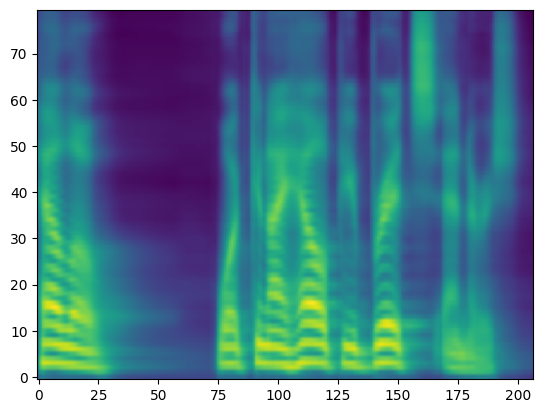

In [42]:
%matplotlib inline
plt.imshow(mel[0].detach().cpu().numpy(), origin="lower", aspect="auto")
plt.show()